In [1]:
%config InlineBackend.figure_format = "retina"

from functools import reduce
import numpy as np
import pandas as pd

from sklearn.preprocessing import KBinsDiscretizer
from sklearn.cluster import SpectralClustering

from plotnine import (ggplot, geom_line, aes, theme_bw, 
                     theme, element_text, labs, scale_colour_manual)

## Import data

In [2]:
df_spx = pd.read_excel("SPX500_Levels.xlsx")
df_rf = pd.read_excel("_RF Historical Data.xlsx")
df_bv = pd.read_excel("columns_bv.xlsx")
df_p = pd.read_excel("columns_p.xlsx")
df_cap = pd.read_excel("columns_cap.xlsx")
df_de = pd.read_excel("columns_de.xlsx")
df_wacc = pd.read_excel("columns_wacc.xlsx")
df_roi = pd.read_excel("columns_roi.xlsx")
df_names = pd.read_excel("columns_name.xlsx")

df_spx["Date"] = pd.to_datetime(df_spx["Date"])
df_spx.set_index("Date", inplace=True)
df_cap["Date"] = pd.to_datetime(df_cap["Date"])
df_cap.set_index("Date", inplace=True)
df_p["Date"] = pd.to_datetime(df_p["Date"])
df_p.set_index("Date", inplace=True)
df_bv["Date"] = pd.to_datetime(df_bv["Date"])
df_bv.set_index("Date", inplace=True)
df_de["Date"] = pd.to_datetime(df_de["Date"])
df_de.set_index("Date", inplace=True)
df_wacc["Date"] = pd.to_datetime(df_wacc["Date"])
df_wacc.set_index("Date", inplace=True)
df_roi["Date"] = pd.to_datetime(df_roi["Date"])
df_roi.set_index("Date", inplace=True)
df_names["Date"] = pd.to_datetime(df_names["Date"])
df_names.set_index("Date", inplace=True)

df_rf.set_index("Period", inplace=True)
df_rf.index.name = "Date"

## Process the data

In [5]:
df_ret = df_p.resample("ME").last().pct_change(fill_method=None)
cond1 = (df_ret.isna().sum() < 20)
cond2 = (df_cap.isna().sum() < 20)
cond3 = ((df_ret == 0).sum() < 20)

cond = np.logical_and.reduce([cond1, cond2, cond3], axis=0)
cond4 = df_de.resample("QE").last().isna().sum() < 3
cond = np.logical_and(cond, cond4)

df_ret1 = df_ret.loc[:, cond].dropna()
df_p1 = df_p.loc[:, cond].ffill().dropna()
df_bv1 = df_bv.loc[:, cond].ffill().dropna()
df_cap1 = df_cap.loc[:, cond].ffill().dropna()
df_de1 = df_de.loc[:, cond].ffill().dropna()
df_wacc1 = df_wacc.loc[:, cond].ffill().dropna()
df_roi1 = df_roi.loc[:, cond].ffill().dropna()

df_rf1 = df_rf.resample("ME").last()
df_rf1 = (1 + df_rf1).pct_change().dropna()
# df_rf2 = df_rf1.loc[[date in df_ret1.index.values.tolist() for date in df_rf1.index.values.tolist()]]

DATES = reduce(np.intersect1d, [df_ret1.index.values, df_p1.index.values, df_bv1.index.values, df_cap1.index.values, df_wacc1.index.values, df_roi1.index.values])


In [7]:
def port_ret(bins, ret, n):

    mask = bins == n

    return pd.concat([ret.loc[[date], m] for date, m in zip(ret.index, mask.T)], axis=0).mean(axis=1)

def form_port(n, df_ret, df_split_factor):
    
    enc = KBinsDiscretizer(n_bins=n, encode="ordinal", strategy="quantile")

    bins = enc.fit_transform(df_split_factor)

    PortRets = pd.concat([port_ret(bins, df_ret, i) for i in range(n)], axis=1)

    return PortRets

names = ["ret", "p", "bv", "cap", "de", "wacc", "roi", "rf"]
dfs = [df_ret1, df_p1, df_bv1, df_cap1, df_de1, df_wacc1, df_roi1, df_rf1]
dfs = {name: df.loc[[date in DATES.tolist() for date in df.index.values.tolist()], :] for name, df in zip(names, dfs)}

MarketCap = dfs["cap"].values.sum(axis=1)
caps = pd.DataFrame(data = dfs["cap"].values / MarketCap.reshape(-1, 1))

PortRets5 = form_port(5, dfs["ret"], caps.shift().dropna().T)
PortRets10 = form_port(10, dfs["ret"], caps.shift().dropna().T)
PortRets20 = form_port(20, dfs["ret"], caps.shift().dropna().T)

In [ ]:
# How the raw returns look like
dfs['ret']

,6,7,8,9,10,12,13,16,17,18,...,3281,3284,3289,3300,3303,3305,2718,2552,2852,3215
Date,,,,,,,,,,,,,,,,,,,,,
2011-04-30,0.067025,0.012105,0.079581,-0.039662,0.043255,0.072573,0.060452,0.004337,0.051260,0.028920,...,0.106878,0.027611,-0.028136,0.096704,-0.002543,0.047070,0.060822,0.003180,0.047998,0.085768
2011-05-31,0.034536,-0.044753,0.007232,-0.079541,-0.064757,0.027940,-0.034491,-0.036385,-0.038473,0.013788,...,0.043090,0.108834,-0.021713,-0.003243,-0.144041,-0.050744,0.001000,-0.151009,0.019777,-0.002259
2011-06-30,0.002300,0.034733,-0.030654,-0.028251,-0.006857,0.060978,-0.055073,-0.009959,-0.003852,-0.002092,...,0.027330,-0.029005,-0.039868,-0.022898,-0.056590,0.022961,0.055421,0.114053,-0.036454,0.006172
2011-07-31,-0.012919,0.069477,-0.027638,-0.048739,-0.051770,0.004121,-0.053557,0.168986,-0.064118,-0.034597,...,-0.085693,-0.044996,-0.050514,-0.074017,-0.027624,-0.023381,-0.014887,-0.025899,0.013620,-0.094830
2011-08-31,0.009598,-0.042701,-0.042045,-0.234157,-0.199710,-0.041930,-0.040777,-0.001291,-0.058182,0.021538,...,0.029767,0.008843,-0.191163,-0.014244,-0.073052,-0.114436,-0.025001,-0.131060,-0.042102,-0.069089
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2024-03-31,-0.043585,0.031885,0.029331,0.094248,0.068791,-0.099377,0.045465,-0.054790,0.159742,0.161156,...,-0.012644,-0.024526,0.085023,0.023525,0.043991,0.087265,0.077988,0.135576,0.021887,0.097631
2024-07-31,0.024603,-0.053764,-0.069063,0.067600,0.093461,-0.013931,0.026680,0.038838,0.240337,0.049004,...,0.082617,-0.017685,0.151070,0.013845,-0.166321,-0.015155,0.015205,0.149714,0.084601,0.038514
2024-08-31,0.070992,-0.013667,0.027766,-0.001446,0.009511,0.121098,0.096151,0.046618,0.062643,0.083872,...,-0.123727,0.055061,-0.007549,0.158608,0.002643,0.105884,0.115594,0.002728,0.027181,0.055338


# Spectral Clustering approach

In [10]:
def form_port_spectral(n, df_ret, window=12, affinity='precomputed', n_neighbors=10, assign_labels='kmeans', n_top=5):
    results = []
    top_portfolio_returns = []
    portfolio_stocks = []
    
    for i in range(window, len(df_ret)):
        # Get rolling window data
        ret_window = df_ret.iloc[i-window:i]
        
        # Calculate correlation matrix for the window
        corr_matrix = ret_window.corr().fillna(0)
        
        # Convert correlation to similarity
        if affinity == 'precomputed':
            similarity = (corr_matrix + 1) / 2
        else:
            similarity = ret_window.T
        
        # Apply spectral clustering
        clustering = SpectralClustering(
            n_clusters=n,
            affinity=affinity,
            n_neighbors=n_neighbors,
            assign_labels=assign_labels,
            random_state=42
        )
        
        clusters = clustering.fit_predict(similarity)

        # Calculate returns for each cluster
        current_ret = df_ret.iloc[i]
        cluster_returns = [current_ret[clusters == j].mean() for j in range(n)]
        results.append(cluster_returns)
        
        # For top portfolio construction
        cum_rets = (1 + ret_window).prod() - 1
        top_stocks_portfolio = []
        
        # Select top performing stocks from each cluster
        for j in range(n):
            cluster_stocks = df_ret.columns[clusters == j]
            cluster_cum_rets = cum_rets[cluster_stocks]
            top_n_stocks = cluster_cum_rets.nlargest(n_top).index
            top_stocks_portfolio.extend(top_n_stocks)
        
        # Calculate equal-weighted portfolio return for top stocks
        top_port_ret = current_ret[top_stocks_portfolio].mean()
        top_portfolio_returns.append(top_port_ret)

        portfolio_stocks.append(top_stocks_portfolio)
        
        # Store cluster assignments
        if i == window:
            cluster_assignments = pd.DataFrame(
                [clusters], 
                columns=df_ret.columns,
                index=[df_ret.index[i]]
            )
        else:
            cluster_assignments.loc[df_ret.index[i]] = clusters
    
    # Create DataFrames for returns
    port_rets = pd.DataFrame(results, 
                           index=df_ret.index[window:],
                           columns=range(n))
    
    top_port_rets = pd.Series(top_portfolio_returns,
                             index=df_ret.index[window:],
                             name='top_portfolio')
    
    portfolio = pd.DataFrame(portfolio_stocks,
                                    index=df_ret.index[window:],
                                    columns=np.repeat(range(n), n_top))
    
    # Calculate cumulative returns
    port_cum_rets = (1 + port_rets).cumprod()
    top_port_cum_rets = (1 + top_port_rets).cumprod()
    
    return port_rets, cluster_assignments, top_port_rets, top_port_cum_rets, portfolio

In [11]:
CustomPortRets, CustomClusterAssign, TopPortRets, TopPortRetsCumulative, StocksPortfolio = form_port_spectral(10, dfs["ret"])
CustomPortRets_nn, CustomClusterAssign_nn, TopPortRets_nn, TopPortRetsCumulative_nn, StocksPortfolio_nn = form_port_spectral(10, dfs["ret"], affinity='nearest_neighbors')

In [12]:
StocksPortfolioNames = StocksPortfolio.copy()
StocksPortfolioNames_nn = StocksPortfolio_nn.copy()

def convert_to_name(row):
    return row.map(lambda x: df_names.loc[row.name, str(int(x))] if pd.notnull(x) else x)

StocksPortfolioNames = StocksPortfolioNames.apply(convert_to_name, axis=1)
StocksPortfolioNames_nn = StocksPortfolioNames_nn.apply(convert_to_name, axis=1)

In [13]:
dates_to_check = ['2012-12-31', '2015-12-31', '2018-12-31', '2021-12-31', '2024-12-31']
print("Spectral Clustering based on correlation matrix:")
# Display portfolio names for specified dates
for date in dates_to_check:
    try:
        print(f"\nPortfolio composition on {date}:")
        print(StocksPortfolioNames.loc[date])
    except KeyError:
        closest_date = StocksPortfolioNames.index[StocksPortfolioNames.index <= date][-1]
        print(f"\nPortfolio composition on {closest_date} (closest available to {date}):")
        print(StocksPortfolioNames.loc[closest_date])

Spectral Clustering based on correlation matrix:

Portfolio composition on 2012-12-31:
0                                    CarMax, Inc.
0                     The Progressive Corporation
0                                 The Cigna Group
0                       The J. M. Smucker Company
0                                  The Kroger Co.
1                                       eBay Inc.
1                             Comcast Corporation
1                                       Visa Inc.
1    Fidelity National Information Services, Inc.
1              American International Group, Inc.
2                              Lennar Corporation
2                     Bank of America Corporation
2                   Regions Financial Corporation
2                               D.R. Horton, Inc.
2                        The Allstate Corporation
3                      Constellation Brands, Inc.
3                       Valero Energy Corporation
3                                 Globe Life Inc.
3            

In [14]:
print("\nSpectral Clustering based on nearest neighbors:")

for date in dates_to_check:
    try:
        print(f"\nPortfolio composition on {date}:")
        print(StocksPortfolioNames_nn.loc[date])
    except KeyError:
        closest_date = StocksPortfolioNames_nn.index[StocksPortfolioNames_nn.index <= date][-1]
        print(f"\nPortfolio composition on {closest_date} (closest available to {date}):")
        print(StocksPortfolioNames_nn.loc[closest_date])


Spectral Clustering based on nearest neighbors:

Portfolio composition on 2012-12-31:
0                         The Sherwin-Williams Company
0                             Brown-Forman Corporation
0                                          Biogen Inc.
0                    McCormick & Company, Incorporated
0                                Quanta Services, Inc.
1                                Gilead Sciences, Inc.
1                                        Revvity, Inc.
1                             Eastman Chemical Company
1                                 Snap-on Incorporated
1                         CF Industries Holdings, Inc.
2                        Regions Financial Corporation
2                                    D.R. Horton, Inc.
2                             Vulcan Materials Company
2                                 Weyerhaeuser Company
2                                           Apple Inc.
3                                 NextEra Energy, Inc.
3                                

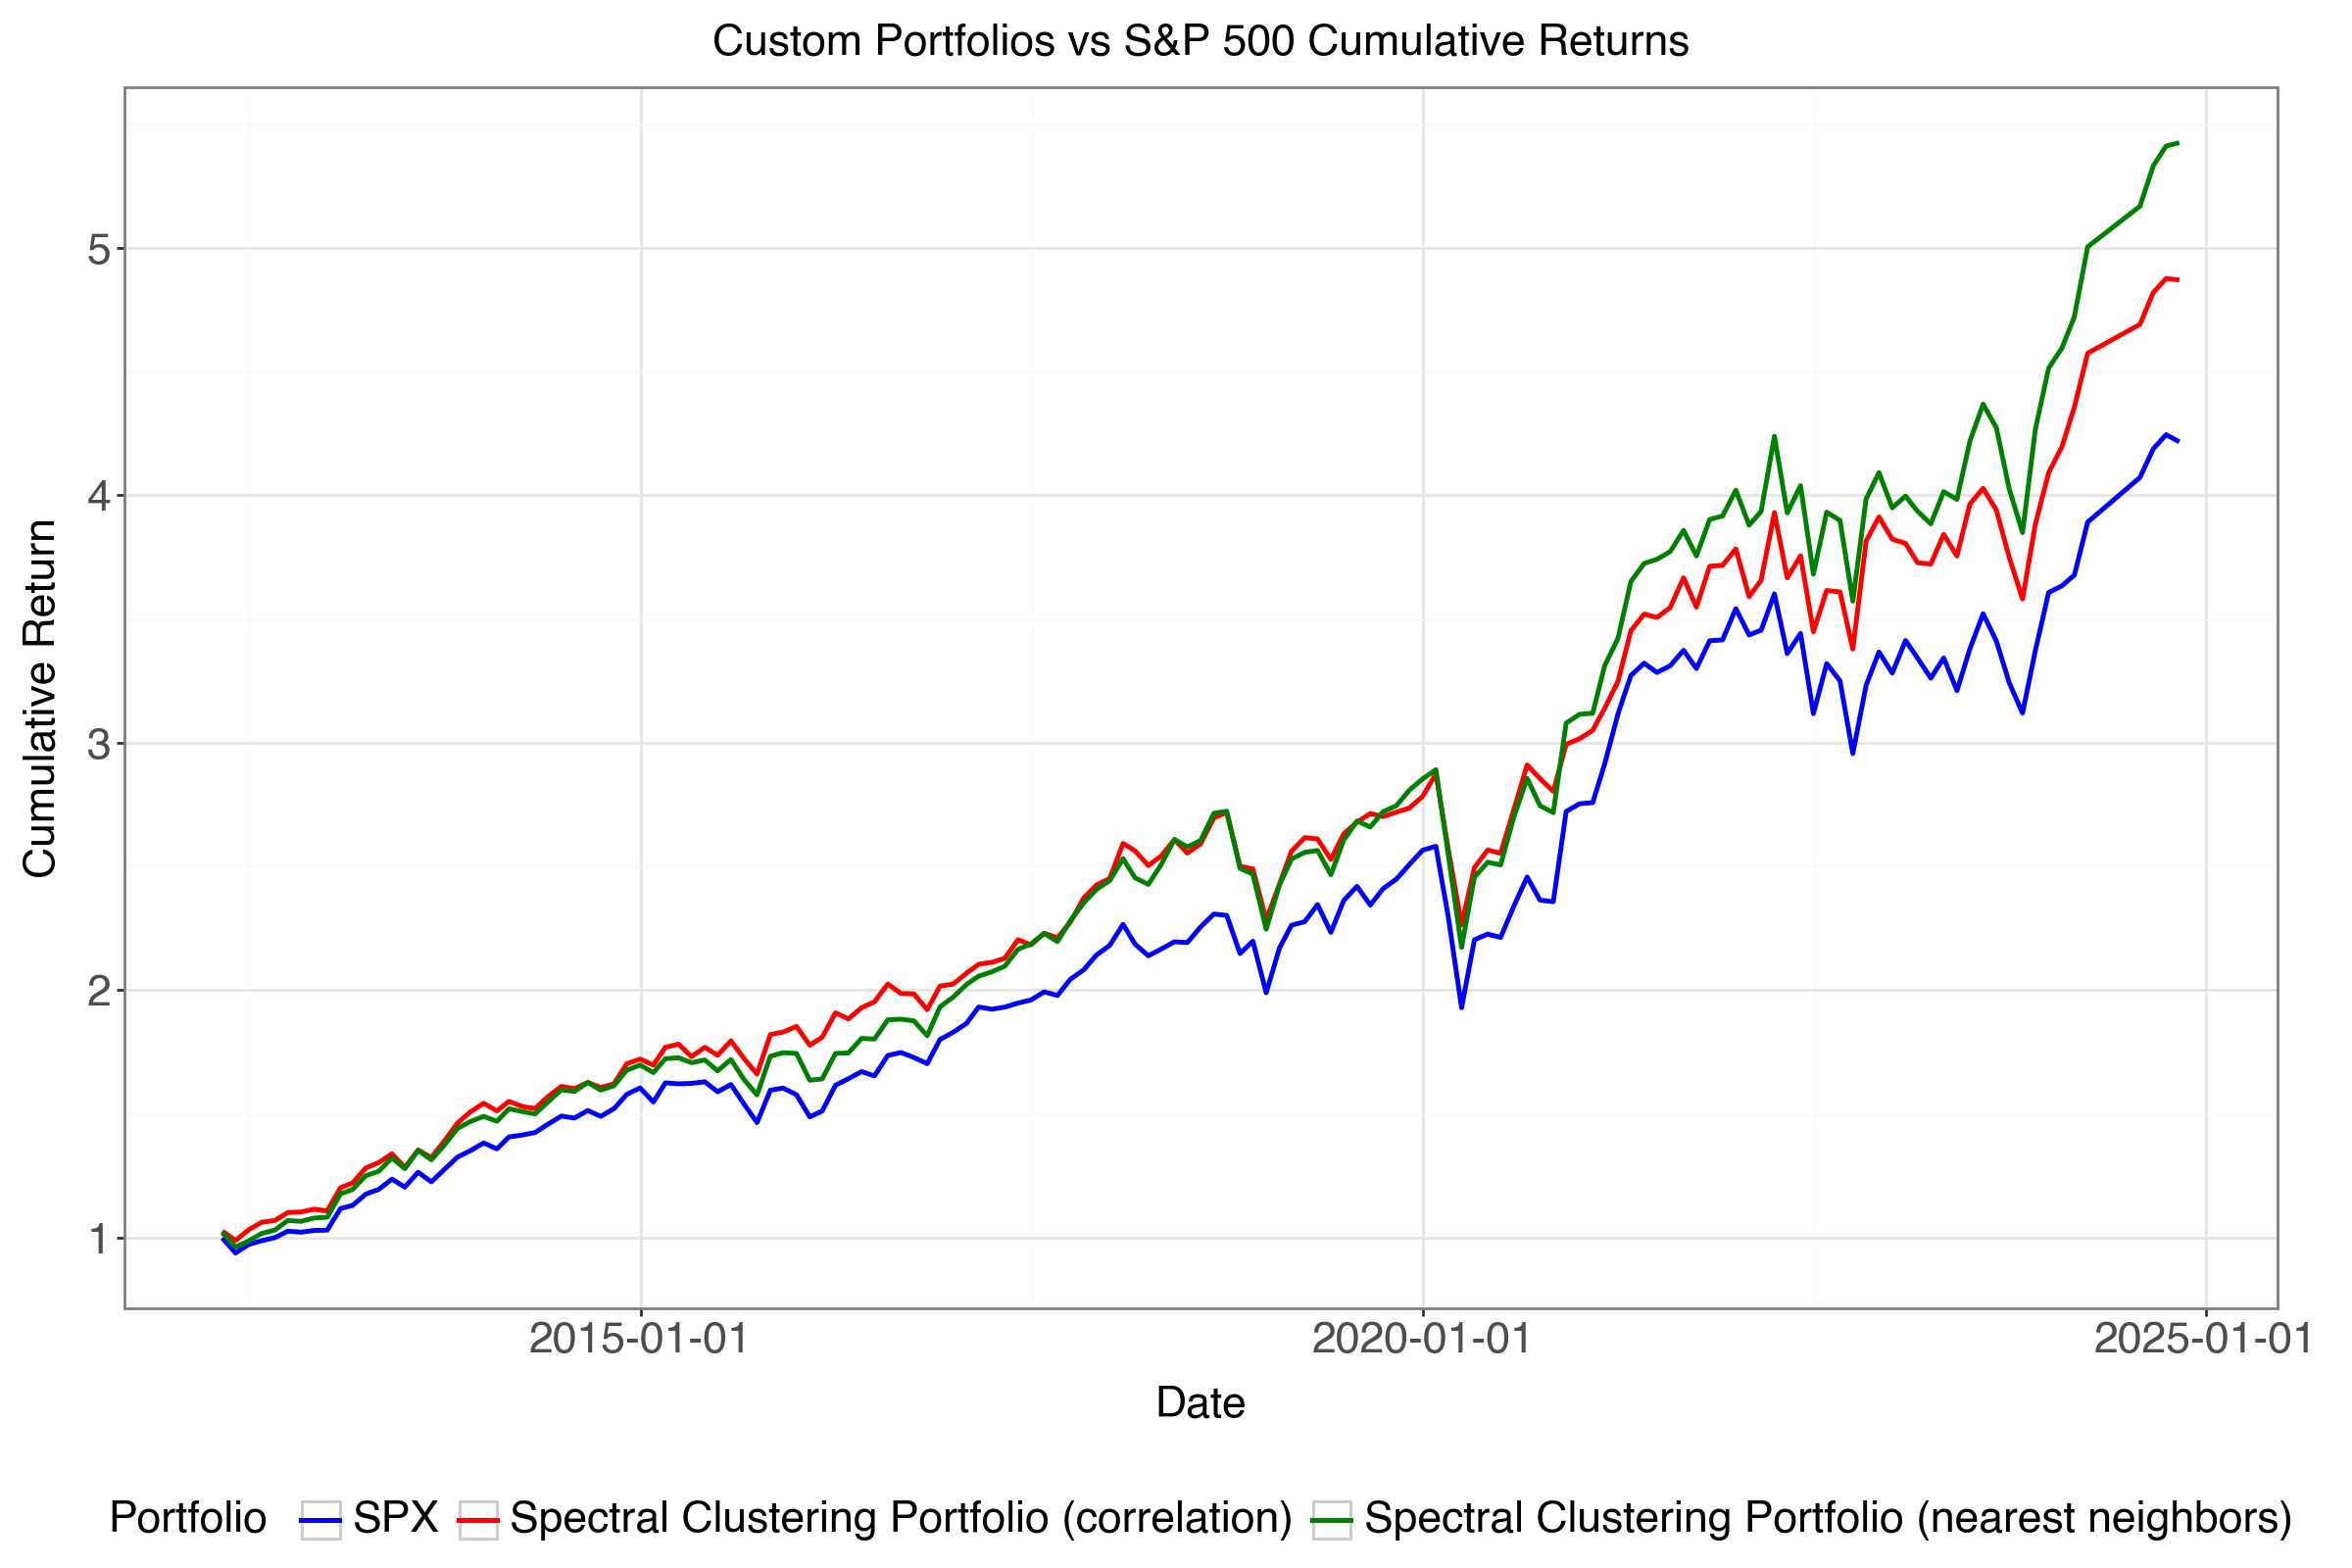

In [39]:
spx_returns = df_ret1.mean(axis=1)
spx_returns = spx_returns[spx_returns.index >= TopPortRetsCumulative.index[0]]
spx_returns = spx_returns[spx_returns.index <= TopPortRetsCumulative.index[-1]]
spx_cum_returns = (1 + spx_returns).cumprod()

comparison_df = pd.DataFrame({
    'Date': TopPortRetsCumulative.index,
    'Spectral Clustering Portfolio (correlation)': TopPortRetsCumulative.values,
    'Spectral Clustering Portfolio (nearest neighbors)': TopPortRetsCumulative_nn.values,
    'SPX': spx_cum_returns.values
}).melt(id_vars=['Date'], var_name='Portfolio', value_name='Cumulative Return')

(ggplot(comparison_df, aes('Date', 'Cumulative Return', color='Portfolio'))
 + geom_line(size=1)
 + theme_bw()
 + theme(figure_size=(12, 8),
         text=element_text(size=16),
         axis_text_x=element_text(angle=0, hjust=0.5),
         legend_position='bottom')
 + labs(title='Custom Portfolios vs S&P 500 Cumulative Returns')
 + scale_color_manual(values=['blue', 'red', 'green'])
)

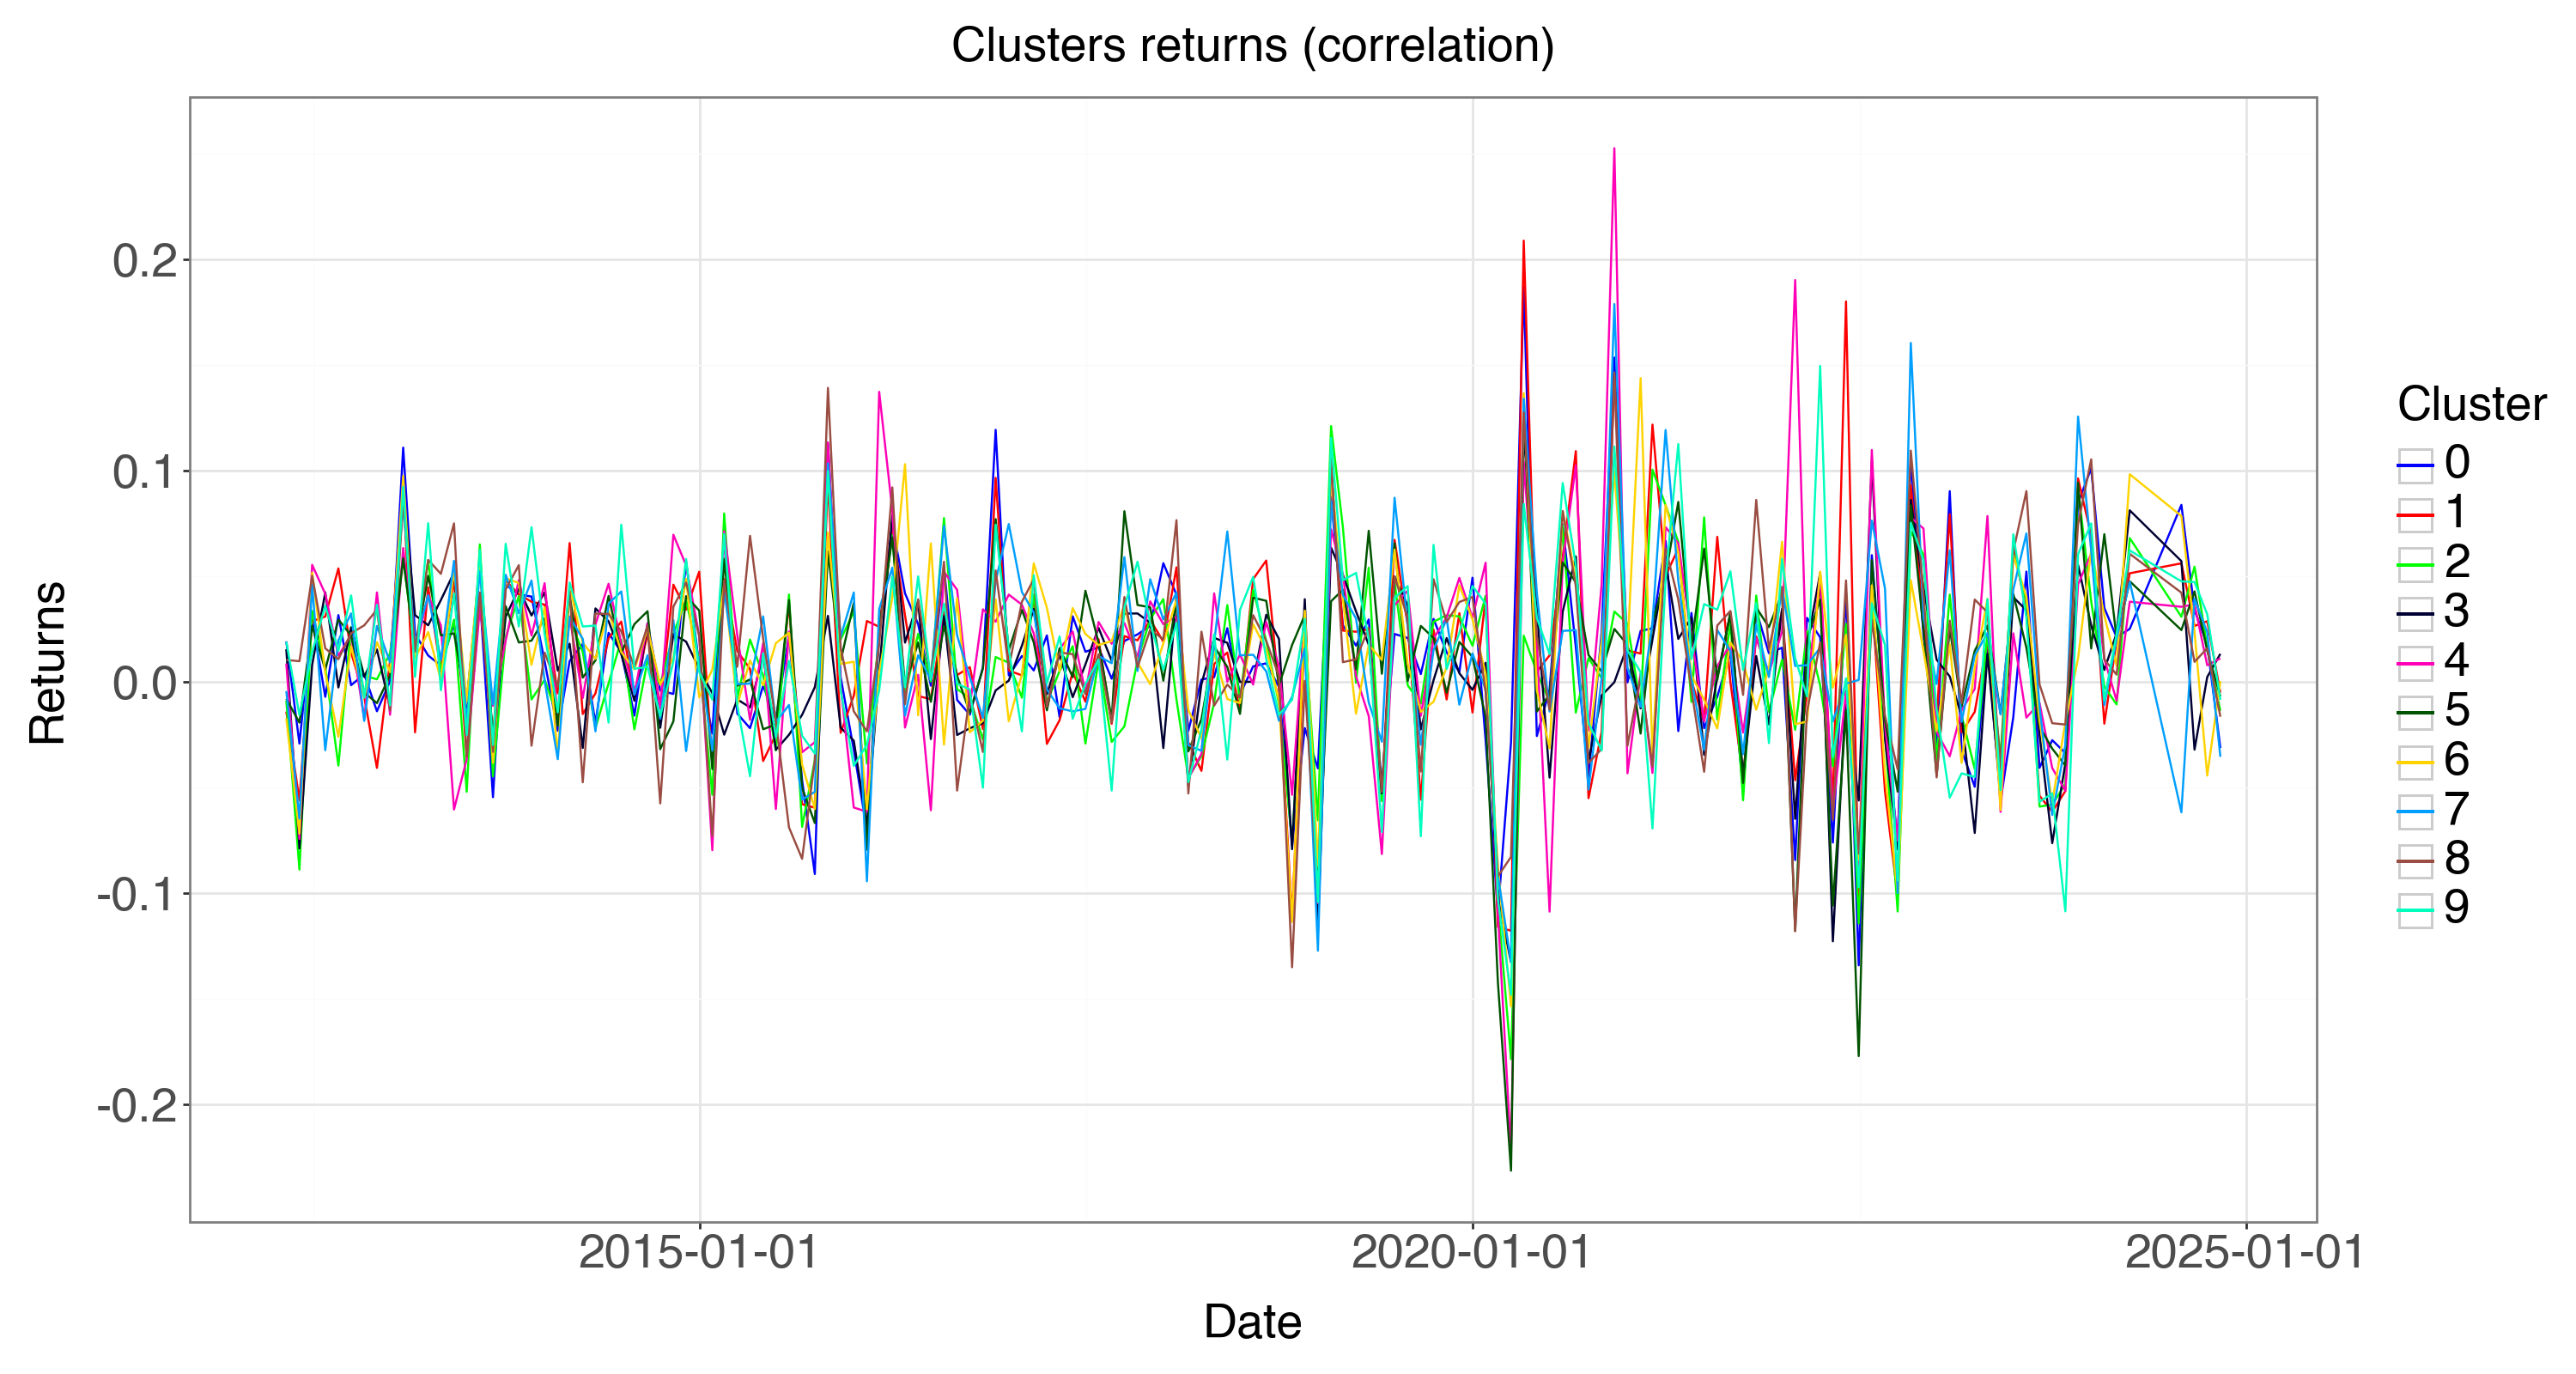

In [34]:
PortRets_long = pd.melt(CustomPortRets.reset_index(), id_vars="Date")
PortRets_long.rename({
    "variable": "Cluster", 
    "value": "Returns"
}, axis=1, inplace=True)

p1 = (
            ggplot(PortRets_long, aes("Date", "Returns")) 
            + geom_line(aes(colour="Cluster")) 
            + theme_bw()
            + theme(axis_text_x=element_text(angle=0, hjust=0.5))
            + theme(figure_size=(15, 8)) 
            + theme(text = element_text(size = 20))
            + labs(title='Clusters returns (correlation)')
            + scale_colour_manual(values=["#0000FF", "#FF0000", "#00FF00", "#000033", "#FF00B6", "#005300", "#FFD300",
                                          "#009FFF", "#9A4D42", "#00FFBE", "#783FC1", "#1F9698", "#FFACFD", "#B1CC71",
                                          "#F1085C", "#FE8F42", "#DD00FF", "#201A01", "#720055", "#766C95", "#02AD24",
                                          "#C8FF00", "#886C00", "#FFB79F", "#858567", "#A10300", "#14F9FF", "#00479E",
                                          "#DC5E93", "#93D4FF", "#004CFF", "#F2F318"])
            )

p1.show()

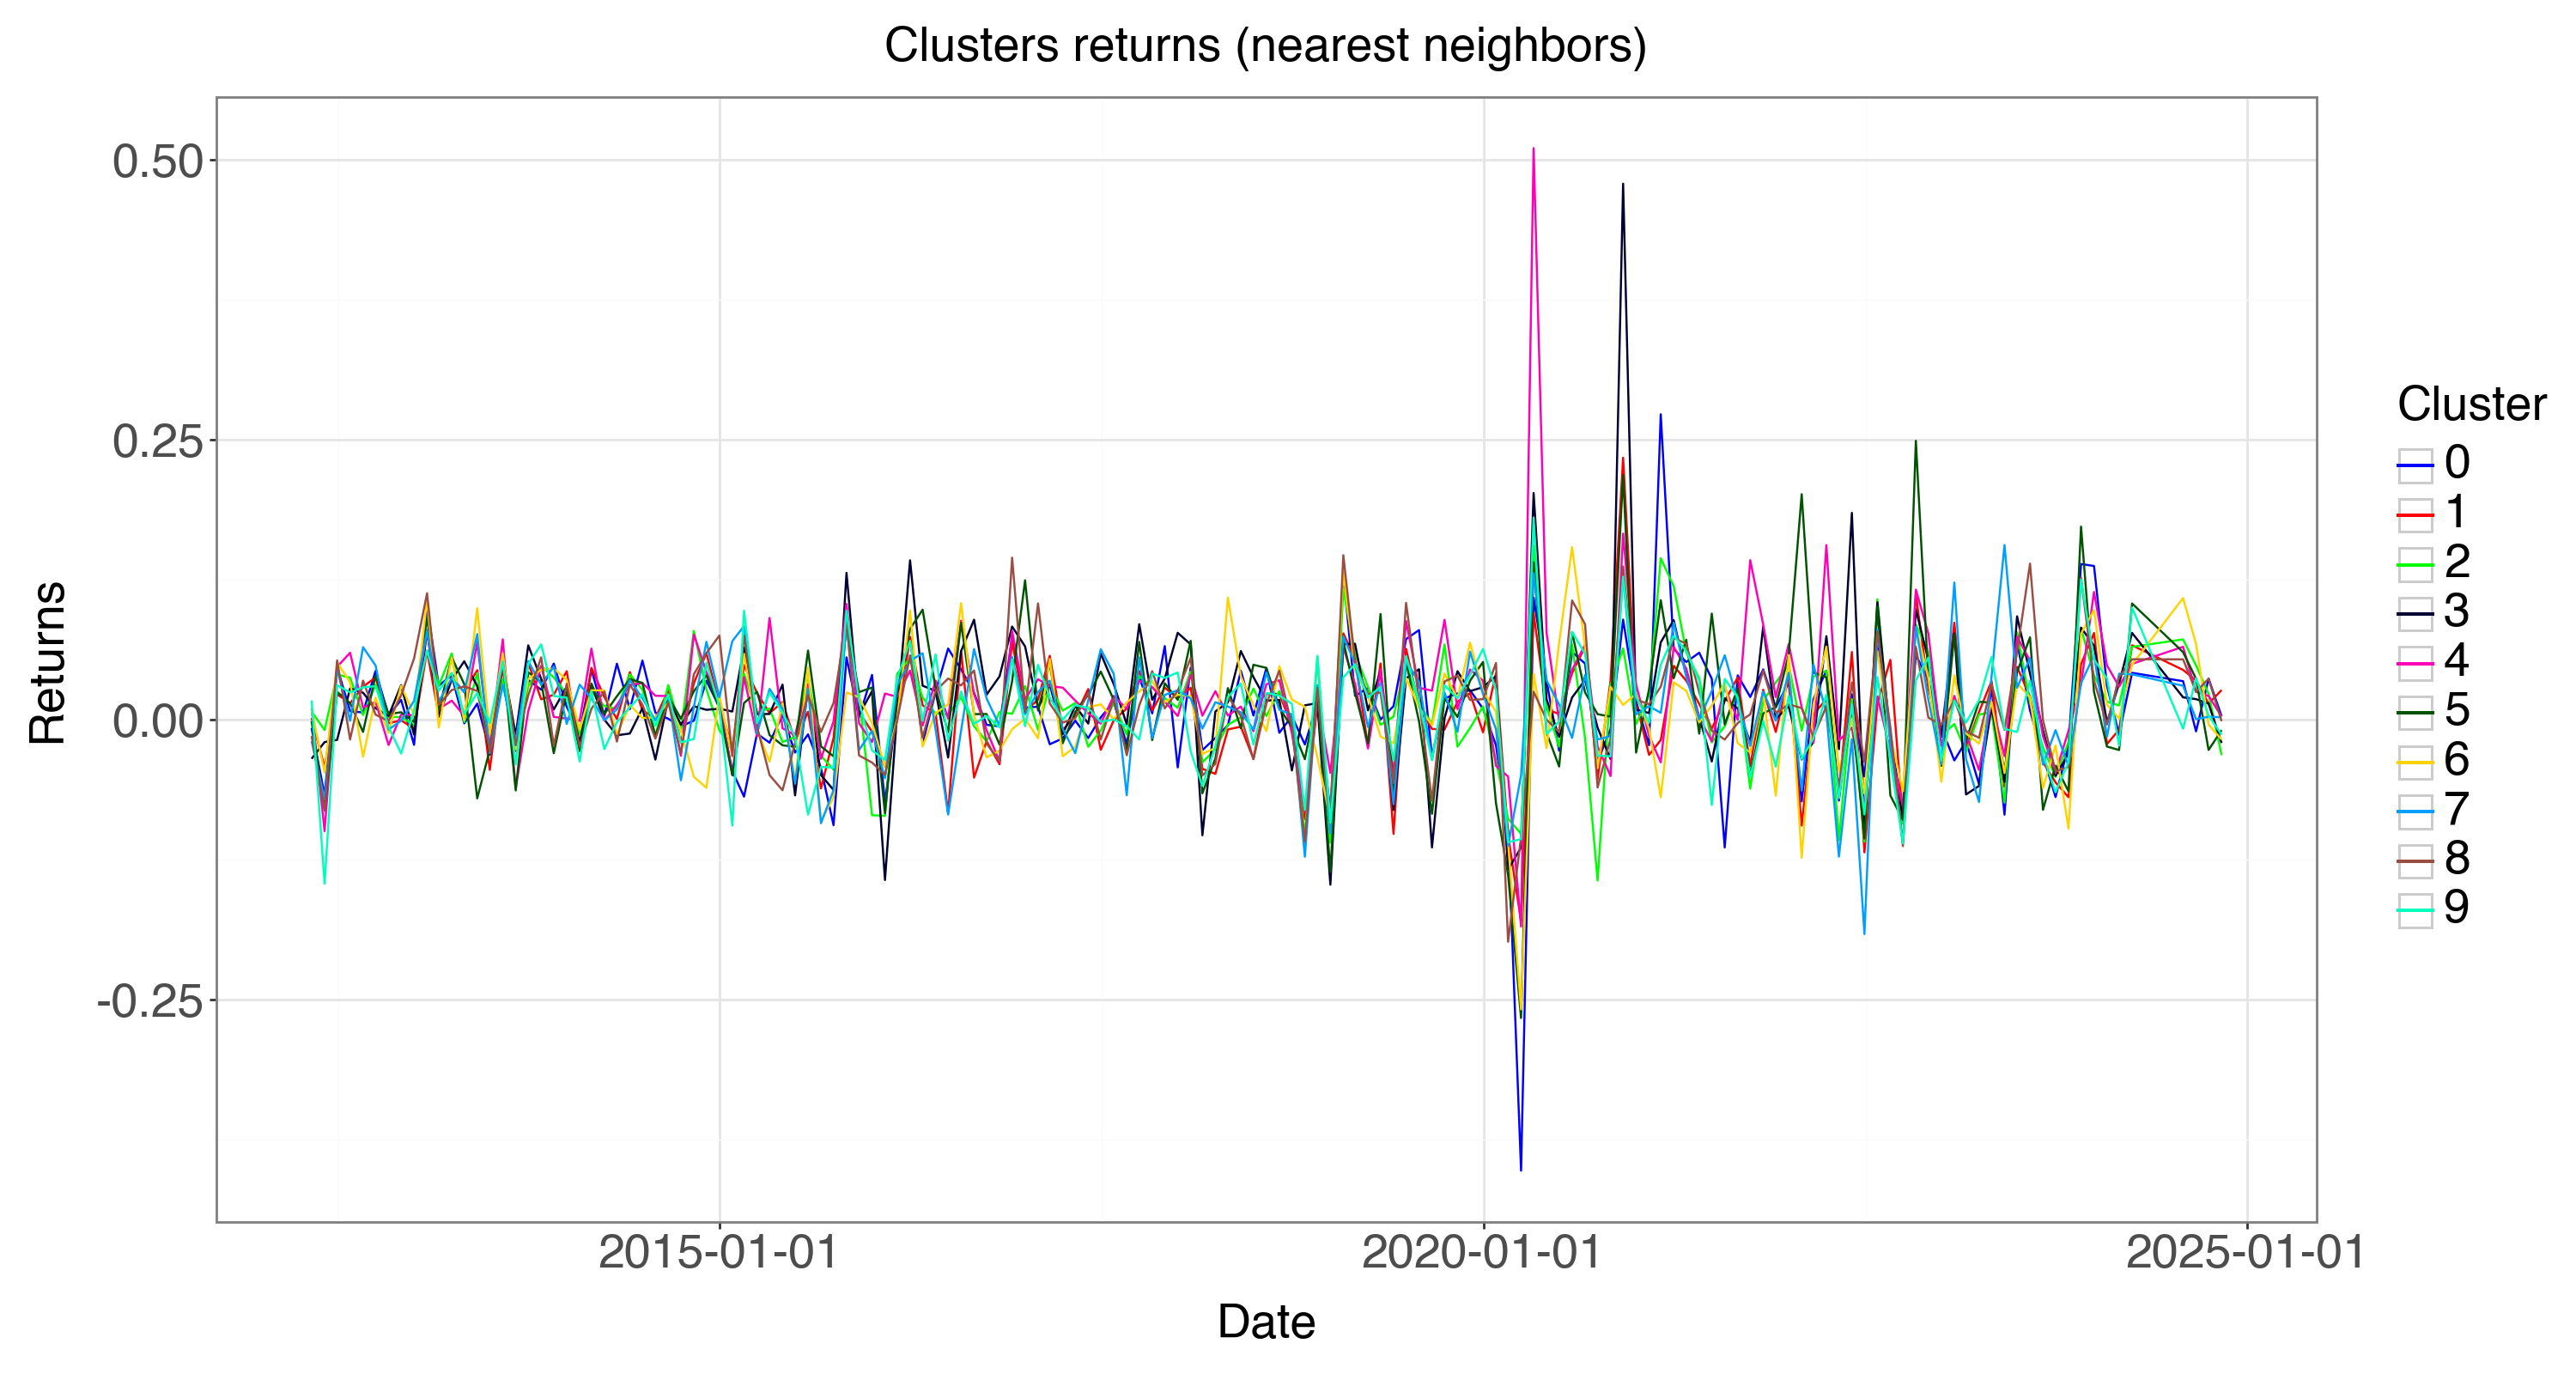

In [35]:
PortRets_long = pd.melt(CustomPortRets_nn.reset_index(), id_vars="Date")
PortRets_long.rename({
    "variable": "Cluster", 
    "value": "Returns"
}, axis=1, inplace=True)

p2 = (
            ggplot(PortRets_long, aes("Date", "Returns")) 
            + geom_line(aes(colour="Cluster")) 
            + theme_bw()
            + theme(axis_text_x=element_text(angle=0, hjust=0.5))
            + theme(figure_size=(15, 8)) 
            + theme(text = element_text(size = 20))
            + labs(title='Clusters returns (nearest neighbors)')
            + scale_colour_manual(values=["#0000FF", "#FF0000", "#00FF00", "#000033", "#FF00B6", "#005300", "#FFD300",
                                          "#009FFF", "#9A4D42", "#00FFBE", "#783FC1", "#1F9698", "#FFACFD", "#B1CC71",
                                          "#F1085C", "#FE8F42", "#DD00FF", "#201A01", "#720055", "#766C95", "#02AD24",
                                          "#C8FF00", "#886C00", "#FFB79F", "#858567", "#A10300", "#14F9FF", "#00479E",
                                          "#DC5E93", "#93D4FF", "#004CFF", "#F2F318"])
            )

p2.show()